DATE: 

AUTHOR: Temi

USAGE: This notebook helps collate ENFORMER tracks per region and aggregates them

In [1]:
import pandas as pd
import os, sys, h5py, collections
from tqdm import tqdm
import numpy as np

In [2]:
# these are the bins
upstream = list(range(0, 8))
center = [8]
downstream = list(range(9, 17))

exec(open('./utility-functions.py').read(), globals(), globals())

In [2]:
TF = 'FOXA1'
cell_line = 'LuCaP'
motif_bin = 448

project_dir = '/projects/covid-ct/imlab/users/temi/projects/TFXcan'
kawakami_training_directory = '/projects/covid-ct/imlab/users/temi/projects/TFXcan/enformer_predictions/kawakami-train'
kawakami_test_directory = '/projects/covid-ct/imlab/users/temi/projects/TFXcan/enformer_predictions/kawakami-test'

# the motif regons file
# kawakami_training_motif_regions = f'{project_dir}/data/train-test-val/kawakami_training_motif_regions.txt'
# kawakami_test_motif_regions = f'{project_dir}/data/train-test-val/kawakami_test_motif_regions.txt'

kawakami_training_motif_regions = f'{project_dir}/defined_regions/kawakami_training_regions.txt'
kawakami_test_motif_regions = f'{project_dir}/defined_regions/kawakami_test_regions.txt'

kawakami_training_prediction_log = f'{project_dir}/log/log_ref_kawakami_{TF}_{cell_line}.csv'
kawakami_test_prediction_log = f'{project_dir}/log/log_ref_kawakami-test_{TF}_{cell_line}.csv'

In [183]:
# read in the motif regions data
motif_training_regions_data = pd.read_table(kawakami_training_motif_regions, sep=' ')
motif_test_regions_data = pd.read_table(kawakami_test_motif_regions, sep=' ')

In [184]:
motif_training_regions_data.loc[motif_training_regions_data['motif_name'] == 'TN1350', ]['num'].values[0]

0

In [185]:
# read in the log file
training_log, test_log = pd.read_csv(kawakami_training_prediction_log), pd.read_csv(kawakami_test_prediction_log)
training_log.head(), training_log.shape, test_log.head(), test_log.shape

(     motif     status
 0  TP27935  completed
 1  TP30057  completed
 2  TP34563  completed
 3  TP22285  completed
 4  TP27935  completed,
 (909, 2),
      motif     status
 0  TP35198  completed
 1  TP33352  completed
 2  TP22333  completed
 3  TP32959  completed
 4  TP26228  completed,
 (1856, 2))

Read in the training data

In [187]:
motif_training_regions_data.motif_name

0      TN1350
1        TN81
2       TN679
3       TN819
4       TN511
        ...  
818    TN1526
819     TN505
820     TN627
821    TN1409
822     TN678
Name: motif_name, Length: 823, dtype: object

In [198]:
#collect predictions using the binding : f'{TF}_{cell_line}_reference_{motif_region}_predictions.h5'

#motif_regions_data.motif_name.tolist()

#log_regions = training_log.motif.tolist()
training_regions = motif_training_regions_data.motif_name.tolist()
binding_counts_train = {}
kawakami_train_predictions = {}

for region in tqdm(training_regions):
    # get the binding counts i.e. num column
    region_h5 = f'{kawakami_training_directory}/{TF}_{cell_line}_reference_{region}_predictions.h5'
    if os.path.isfile(region_h5):
        bc = motif_training_regions_data.loc[motif_training_regions_data['motif_name'] == region, ]['num'].values[0]
        binding_counts_train[region] = bc
        with h5py.File(region_h5, 'r') as f:
            filekey = list(f.keys())[0]

            # should I select tracks? ; maybe not yet
            kawakami_train_predictions[filekey.split(',')[1]] = select_tracks(np.vstack(list(f[filekey])), select_bins=8, motif_bin=motif_bin)

100%|██████████| 823/823 [01:18<00:00, 10.46it/s]


Read in the test data

In [200]:
#collect predictions using the binding : f'{TF}_{cell_line}_reference_{motif_region}_predictions.h5'

#motif_regions_data.motif_name.tolist()

#log_regions = test_log.motif.tolist()
test_regions = motif_test_regions_data.motif_name.tolist()
binding_counts_test = {}
kawakami_test_predictions = {}

for region in tqdm(test_regions):
    region_h5 = f'{kawakami_test_directory}/{TF}_{cell_line}_reference_{region}_predictions.h5'
    if os.path.isfile(region_h5):
        bc = motif_test_regions_data.loc[motif_test_regions_data['motif_name'] == region, ]['num'].values[0]
        binding_counts_test[region] = bc
        with h5py.File(region_h5, 'r') as f:
            filekey = list(f.keys())[0]

            # should I select tracks? ; maybe not yet
            kawakami_test_predictions[filekey.split(',')[1]] = select_tracks(np.vstack(list(f[filekey])), select_bins=8, motif_bin=motif_bin)

100%|██████████| 1618/1618 [06:08<00:00,  4.39it/s]


In [201]:
len(kawakami_train_predictions), len(kawakami_test_predictions), len(binding_counts_train), len(binding_counts_test)

(764, 1515, 764, 1515)

Distribution of training and test data

In [116]:
kmotifs = list(kawakami_train_predictions.keys())
motif_y = ['TP' if m.startswith('TP') else 'TN' for m in kmotifs]
collections.Counter(motif_y)
#region_data['motif_y'] = motif_y

Counter({'TN': 508, 'TP': 256})

In [117]:
kmotifs = list(kawakami_test_predictions.keys())
motif_y = ['TP' if m.startswith('TP') else 'TN' for m in kmotifs]
collections.Counter(motif_y)

Counter({'TN': 928, 'TP': 587})

Aggregate the data

In [227]:
train_aggbymean, train_aggbycenter, train_aggbymean_upstream, train_aggbymean_downstream, train_aggbymean_upstream_downstream = agg_byall(kawakami_train_predictions)
test_aggbymean, test_aggbycenter, test_aggbymean_upstream, test_aggbymean_downstream, test_aggbymean_upstream_downstream = agg_byall(kawakami_test_predictions)

In [228]:
len(binding_counts_train)

764

It is better to leave them as training and test sets

In [37]:
# this code stacks them but I lose which are training or test and I need that information to correlate predictions with Freedman's

# data_aggbycenter = np.row_stack([train_aggbycenter, test_aggbycenter])
# data_aggbymean = np.row_stack([train_aggbymean, test_aggbymean])
# data_aggbymean_upstream = np.row_stack([train_aggbymean_upstream, test_aggbymean_upstream])
# data_aggbymean_downstream = np.row_stack([train_aggbymean_downstream, test_aggbymean_downstream])
# data_aggbymean_upstream_downstream = np.row_stack([train_aggbymean_upstream_downstream, test_aggbymean_upstream_downstream])

# data_list = [data_aggbymean, data_aggbycenter, data_aggbymean_upstream, data_aggbymean_downstream, data_aggbymean_upstream_downstream]

In [127]:
a = pd.Series(range(1, 11))
b = pd.Series(range(11, 21))
pd.concat([a, b], axis=1)

,0,1
0,1,11
1,2,12
2,3,13
3,4,14
4,5,15
5,6,16
6,7,17
7,8,18
8,9,19
9,10,20


In [241]:
def collate_data(data_list, add_bc=[binding_counts_train, binding_counts_test], add_id=[], target_name='binary_counts'):

    # add_bc could be None or a list

    # to do : can supply a list of predictor names

    training_type = ['train', 'test']

    if add_bc is None:
        add_bc = [['NA'] * d.shape[0] for d in data_list]
    else:
        add_bc = [pd.DataFrame(d.items()) for d in add_bc]
    
    data_list = [pd.DataFrame(d) for d in data_list]

    # concatenate the training type and the add_bc
    a = [pd.concat([pd.Series([training_type[i]] * len(add_bc[i]), name='training_type'), add_bc[i]], axis=1) for i,_ in enumerate(add_bc)]

    #concatenate a and data_list appropriatly
    out_list = [pd.concat([a[i], data_list[i]], axis=1) for i,_ in enumerate(data_list)]

    # concat_list = [pd.concat([pd.Series([training_type[i]] * len(add_bc[i]), name='training_type'), pd.Series(add_bc[i]),  data_list[i]], axis=1) for i,_ in enumerate(data_list)]

    out = pd.concat(out_list, axis=0) #pd.concat([train_dt, test_dt], axis=0)

    out_names = ['training_type', 'target', 'binding_counts', target_name]
    out_names.extend([f'f_{i}' for i in out.columns.values[4:]])
    out.set_axis(out_names, axis=1, inplace=True)

    return(out)

In [242]:
collate_data([train_aggbycenter, test_aggbycenter])

,training_type,target,binding_counts,binary_counts,f_1,f_2,f_3,f_4,f_5,f_6,...,f_5304,f_5305,f_5306,f_5307,f_5308,f_5309,f_5310,f_5311,f_5312,f_5313
0,train,TN1350,0,0.0,0.099060,0.113979,0.110115,0.128406,0.097710,0.097368,...,0.078305,0.016928,0.008347,0.005471,0.003669,0.001942,0.002626,0.002915,0.007993,0.009651
1,train,TN81,0,0.0,0.089137,0.127156,0.106862,0.103149,0.069005,0.069195,...,0.154986,0.062153,0.017170,0.029673,0.007046,0.003956,0.005727,0.011298,0.026872,0.037020
2,train,TN679,0,0.0,0.096139,0.099354,0.051745,0.148914,0.067432,0.046579,...,0.079534,0.018713,0.009050,0.006235,0.003351,0.002659,0.002909,0.002459,0.010211,0.009406
3,train,TN819,0,0.0,0.049683,0.037545,0.021408,0.072797,0.035188,0.024142,...,0.106202,0.037158,0.018275,0.013304,0.004790,0.002138,0.003884,0.005323,0.023824,0.016784
4,train,TN511,0,0.0,0.156553,0.083193,0.048997,0.084823,0.077338,0.071219,...,0.112135,0.023291,0.011575,0.007624,0.003135,0.001441,0.002561,0.003354,0.009418,0.007008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,test,TP175776,8,1.0,0.046637,0.049430,0.046871,0.087095,0.059975,0.062710,...,0.071274,0.016046,0.009046,0.005357,0.002759,0.001252,0.002113,0.001692,0.004901,0.006598
1511,test,TP175627,7,1.0,0.136045,0.110253,0.110744,0.138211,0.089393,0.080399,...,0.095960,0.034274,0.012214,0.007809,0.004727,0.002632,0.004203,0.003564,0.036410,0.031990
1512,test,TP177463,1,1.0,0.424758,0.495595,0.659127,0.159793,0.153835,0.138418,...,0.117316,0.031476,0.013263,0.007117,0.009399,0.006466,0.008757,0.008831,0.038256,0.041180
1513,test,TP176481,2,1.0,0.162014,0.141857,0.095272,0.153276,0.148021,0.110233,...,0.142366,0.047124,0.017725,0.011242,0.011749,0.007341,0.008551,0.008769,0.055964,0.054468


In [243]:
data_aggbycenter = collate_data([train_aggbycenter, test_aggbycenter])
data_aggbymean = collate_data([train_aggbymean, test_aggbymean])
data_aggbymean_upstream = collate_data([train_aggbymean_upstream, test_aggbymean_upstream])
data_aggbymean_downstream = collate_data([train_aggbymean_downstream, test_aggbymean_downstream])
data_aggbymean_upstream_downstream = collate_data([train_aggbymean_upstream_downstream, test_aggbymean_upstream_downstream])

data_list = [data_aggbymean, data_aggbycenter, data_aggbymean_upstream, data_aggbymean_downstream, data_aggbymean_upstream_downstream]

In [244]:
data_aggbycenter.shape

(2279, 5317)

Save the data

In [245]:
save_dir = '/projects/covid-ct/imlab/users/temi/projects/TFXcan/defined_regions/train-test-val'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#track_headers = list(range(1, 5314))

In [246]:
data_names = ['aggByMean', 'aggByCenter', 'aggByUpstream', 'aggByDownstream', 'aggByUpstreamDownstream']
for i in range(0, len(data_list)):
    pd.DataFrame(data_list[i]).to_csv(path_or_buf=f'{save_dir}/{data_names[i]}_{TF}_{cell_line}.csv', index=False)

# Kawakami-human (40000) predictions

In [3]:
base_path = '/projects/covid-ct/imlab/users/temi/projects/TFXcan'
reference_predictions_path = f'{base_path}/enformer_predictions/kawakami-reference'

# use the log to select what is avaialable:
logpath = f'{base_path}/log/reference/kawakami-human_predictions_log.csv'

In [4]:
log_data = pd.read_csv(logpath)
log_data.shape

(40085, 4)

For these 85, we probably could not make predictions because of sequence length and other issues

In [5]:
len(log_data.motif.unique()) # there should be 40000

40000

In [6]:
duplicated_rows = log_data.duplicated()

In [7]:
log_data[duplicated_rows]

,motif,individual,status,sequence_type
12434,pos_peak316904,kawakami-human,completed,NaN
12435,pos_peak322104,kawakami-human,completed,NaN
12436,pos_peak270656,kawakami-human,completed,NaN
12437,pos_peak267154,kawakami-human,completed,NaN
12438,pos_peak267191,kawakami-human,completed,NaN
...,...,...,...,...
32506,pos_peak265388,kawakami-human,completed,NaN
32507,pos_peak320499,kawakami-human,completed,NaN
32508,pos_peak271683,kawakami-human,completed,NaN
32509,pos_peak363403,kawakami-human,completed,NaN


In [8]:
len(log_data.loc[log_data['sequence_type'].isnull()].motif.values.tolist())

131

In [9]:
len(log_data.loc[log_data['sequence_type'] == 'ref', ].motif.values.tolist())

39954

Read in the predictions

In [10]:
# read in one of the files
kawakami_predictions = {}

for dt in tqdm(log_data.loc[log_data['sequence_type'] == 'ref', ].motif.values.tolist()):
    fle = f'{reference_predictions_path}/{dt}_predictions.h5'
    if os.path.isfile(fle):
        with h5py.File(fle, 'r') as f:
            filekey = list(f.keys())[0]
            # should I select tracks? ; maybe not yet
            kawakami_predictions[dt] = np.vstack(list(f[filekey]))
    else:
        print('File does not exist')

100%|██████████| 39954/39954 [10:28<00:00, 63.60it/s] 


In [12]:
kmotifs = list(kawakami_predictions.keys())
motif_y = ['pos' if m.startswith('pos') else 'neg' for m in kmotifs]
collections.Counter(motif_y)

Counter({'pos': 19954, 'neg': 20000})

In [13]:
dt_aggbymean, dt_aggbycenter, dt_aggbymean_upstream, dt_aggbymean_downstream, dt_aggbymean_upstream_downstream = agg_byall(kawakami_predictions)

data_list = [dt_aggbymean, dt_aggbycenter, dt_aggbymean_upstream, dt_aggbymean_downstream, dt_aggbymean_upstream_downstream]

In [38]:
save_dir = '/projects/covid-ct/imlab/users/temi/projects/TFXcan/train-test-val/kawakami-human'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [39]:
person = 40000
TF = 'FOXA1'
data_names = ['aggByMean', 'aggByCenter', 'aggByUpstream', 'aggByDownstream', 'aggByUpstreamDownstream']

for i, dt in enumerate(data_list):

    ty = pd.concat([pd.Series(list(kawakami_predictions.keys())), pd.DataFrame(dt)], axis=1)

    column_names = ['id', 'class']
    column_names.extend([f'f_{i}' for i in range(1, ty.shape[1] - 1)])

    ty.set_axis(column_names, axis=1, inplace=True)

    ty.to_csv(path_or_buf=f'{save_dir}/{data_names[i]}_{TF}_{person}.csv.gz', index=False, compression='gzip')

# Freedman ENFORMER predictions

In [3]:
base_path = '/projects/covid-ct/imlab/users/temi/projects/TFXcan'
enformer_predictions_path = f'{base_path}/enformer_predictions/freedman/personalized-enformer'
individual_predictions_path = f'{enformer_predictions_path}/LuCaP_145'

# use the log to select what is avaialable:
logpath = f'{base_path}/log/freedman/LuCaP_145_predictions_log.csv'

In [4]:
# individuals 
individuals = ['LuCaP_145', 'LuCaP_136']

save_dir = '/projects/covid-ct/imlab/users/temi/projects/TFXcan/train-test-val/freedman'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [6]:
TF = 'FOXA1'
data_names = ['aggByMean', 'aggByCenter', 'aggByUpstream', 'aggByDownstream', 'aggByUpstreamDownstream']

for individual in individuals:
    
    logpath = f'{base_path}/log/freedman/{individual}_predictions_log.csv'
    individual_predictions_path = f'{enformer_predictions_path}/{individual}'

    log_data = pd.read_csv(logpath)

    # read in one of the files
    freedman_predictions = {}

    for dt in tqdm(log_data.loc[log_data['sequence_type'] == 'var', ].motif.values.tolist()):
        fle = f'{individual_predictions_path}/{dt}_predictions.h5'
        if os.path.isfile(fle):
            with h5py.File(fle, 'r') as f:
                filekey = list(f.keys())[0]
                # should I select tracks? ; maybe not yet
                freedman_predictions[dt] = np.vstack(list(f[filekey]))
        else:
            print('File does not exist')

    test_aggbymean, test_aggbycenter, test_aggbymean_upstream, test_aggbymean_downstream, test_aggbymean_upstream_downstream = agg_byall(freedman_predictions)

    data_list = [test_aggbymean, test_aggbycenter, test_aggbymean_upstream, test_aggbymean_downstream, test_aggbymean_upstream_downstream]

    for i, dt in enumerate(data_list):

        ty = pd.concat([pd.Series(list(freedman_predictions.keys())), pd.DataFrame(dt)], axis=1)

        column_names = ['id', 'class']
        column_names.extend([f'f_{i}' for i in range(1, ty.shape[1] - 1)])

        ty.set_axis(column_names, axis=1, inplace=True)

        ty.to_csv(path_or_buf=f'{save_dir}/{individual}_{data_names[i]}_{TF}.csv', index=False)

100%|██████████| 3930/3930 [02:23<00:00, 27.41it/s]


In [48]:
log_data = pd.read_csv(logpath)
log_data.shape

(4007, 4)

In [15]:
log_data.tail()

,motif,individual,status,sequence_type
1666,neg_peak6650,LuCaP_145,completed,var
1667,neg_peak11828,LuCaP_145,completed,var
1668,pos_peak136605,LuCaP_145,completed,var
1669,neg_peak751,LuCaP_145,completed,var
1670,pos_peak134422,LuCaP_145,completed,var


In [16]:
#log_data.loc[log_data['sequence_type'] == 'var', ].motif.values.tolist()

In [49]:
# read in one of the files
freedman_predictions = {}

for dt in tqdm(log_data.loc[log_data['sequence_type'] == 'var', ].motif.values.tolist()):
    fle = f'{individual_predictions_path}/{dt}_predictions.h5'
    if os.path.isfile(fle):
        with h5py.File(fle, 'r') as f:
            filekey = list(f.keys())[0]
            # should I select tracks? ; maybe not yet
            freedman_predictions[dt] = np.vstack(list(f[filekey]))
    else:
        print('File does not exist')


100%|██████████| 3944/3944 [00:50<00:00, 78.60it/s] 


In [11]:
kmotifs = list(freedman_predictions.keys())
motif_y = ['pos' if m.startswith('pos') else 'neg' for m in kmotifs]
collections.Counter(motif_y)

NameError: name 'freedman_predictions' is not defined

Aggregating

In [51]:
test_aggbymean, test_aggbycenter, test_aggbymean_upstream, test_aggbymean_downstream, test_aggbymean_upstream_downstream = agg_byall(freedman_predictions)

data_list = [test_aggbymean, test_aggbycenter, test_aggbymean_upstream, test_aggbymean_downstream, test_aggbymean_upstream_downstream]

In [52]:
save_dir = '/projects/covid-ct/imlab/users/temi/projects/TFXcan/train-test-val/freedman'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [53]:
TF = 'FOXA1'
data_names = ['aggByMean', 'aggByCenter', 'aggByUpstream', 'aggByDownstream', 'aggByUpstreamDownstream']

for i, dt in enumerate(data_list):

    ty = pd.concat([pd.Series(list(freedman_predictions.keys())), pd.DataFrame(dt)], axis=1)

    column_names = ['id', 'class']
    column_names.extend([f'f_{i}' for i in range(1, ty.shape[1] - 1)])

    ty.set_axis(column_names, axis=1, inplace=True)

    ty.to_csv(path_or_buf=f'{save_dir}/{person}_{data_names[i]}_{TF}.csv', index=False)
        

## End here for now

In [36]:
train_data = [train_aggbymean, train_aggbycenter, train_aggbymean_upstream, train_aggbymean_downstream, train_aggbymean_upstream_downstream]
train_data_names = ['aggByMean', 'aggByCenter', 'aggByUpstream', 'aggByDownstream', 'aggByUpstreamDownstream']
for i in range(0, len(train_data)):
    pd.DataFrame(train_data[i]).to_csv(path_or_buf=f'{save_dir}/train_{TF}_{cell_line}_{train_data_names[i]}.csv', index=False, header=['class'] + track_headers)

In [ ]:
ind_name = list(train_aggbycenter.keys())[0]
pd.DataFrame(train_aggbycenter['HG00479']).to_csv(path_or_buf=f'{train_test_data_path}/train_aggByCenter_{ind_name}.csv', index=False, header=train_headers)
pd.DataFrame(test_aggbycenter['HG00479']).to_csv(path_or_buf=f'{train_test_data_path}/test_aggByCenter_{ind_name}.csv', index=False, header=test_headers)

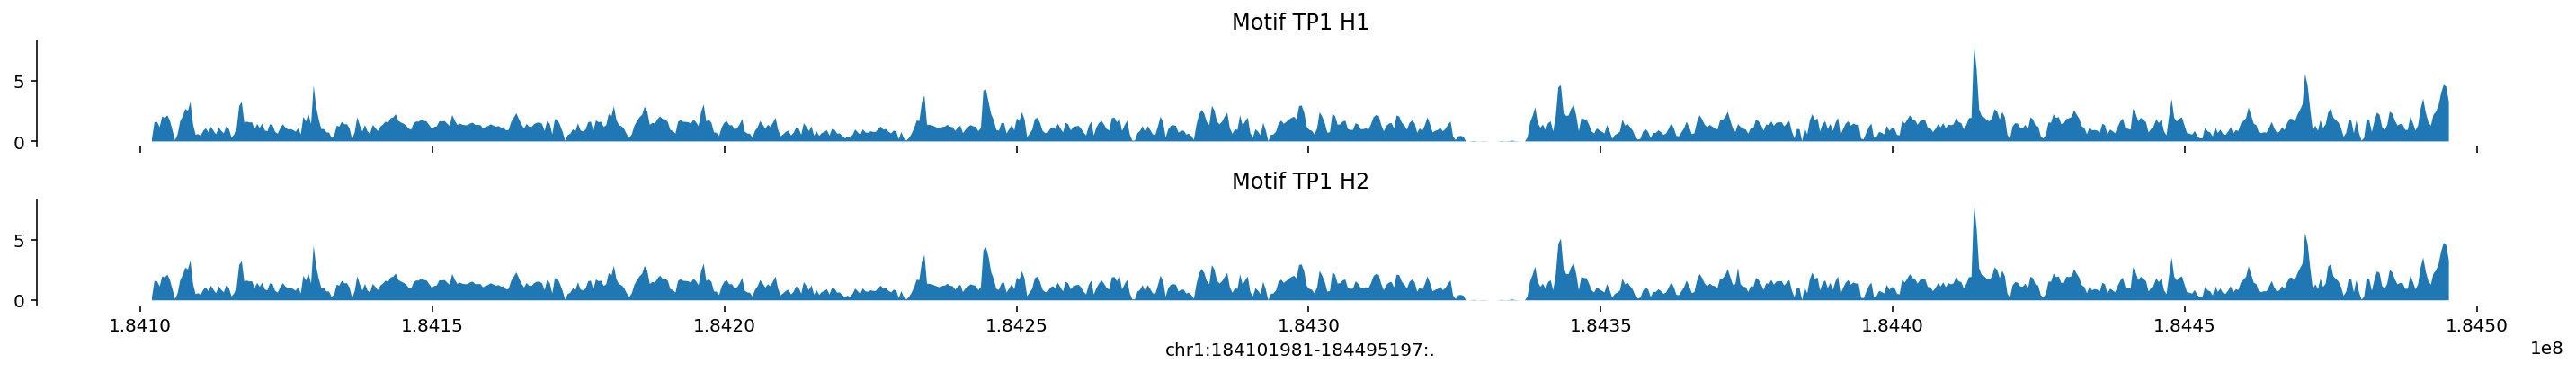

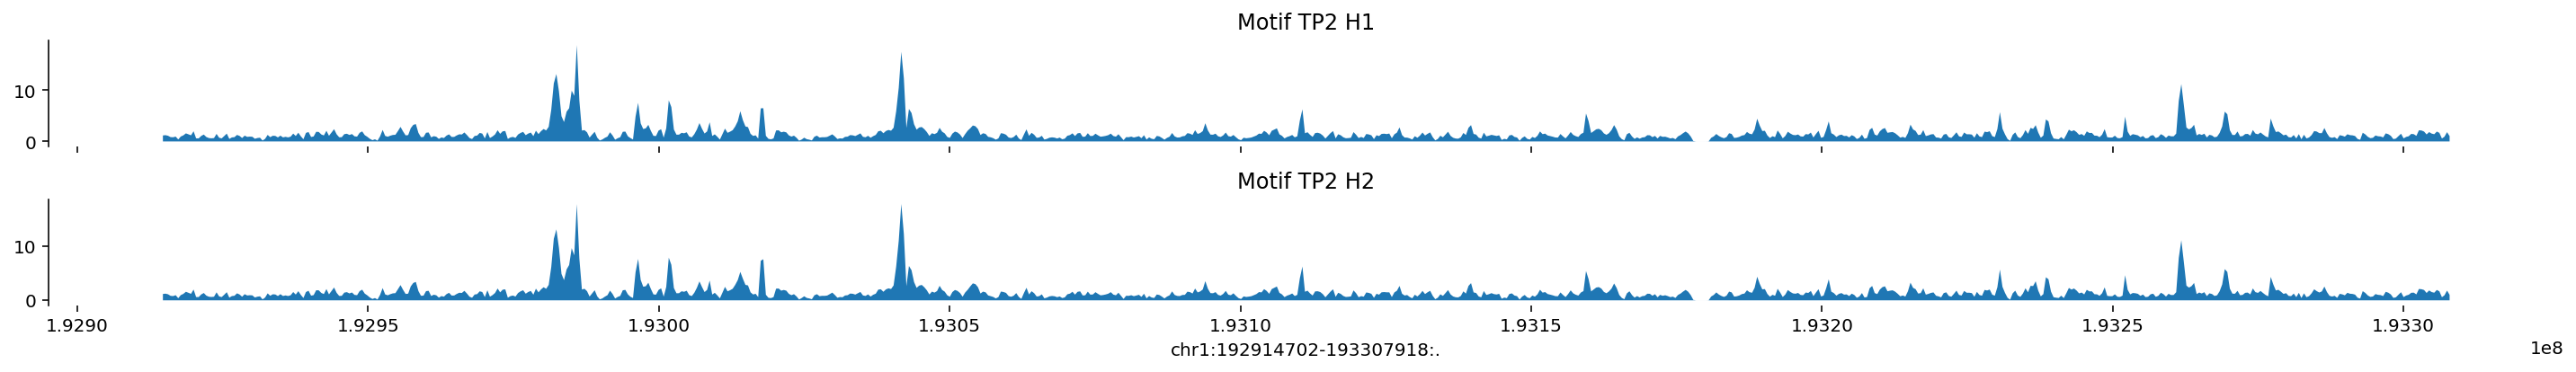

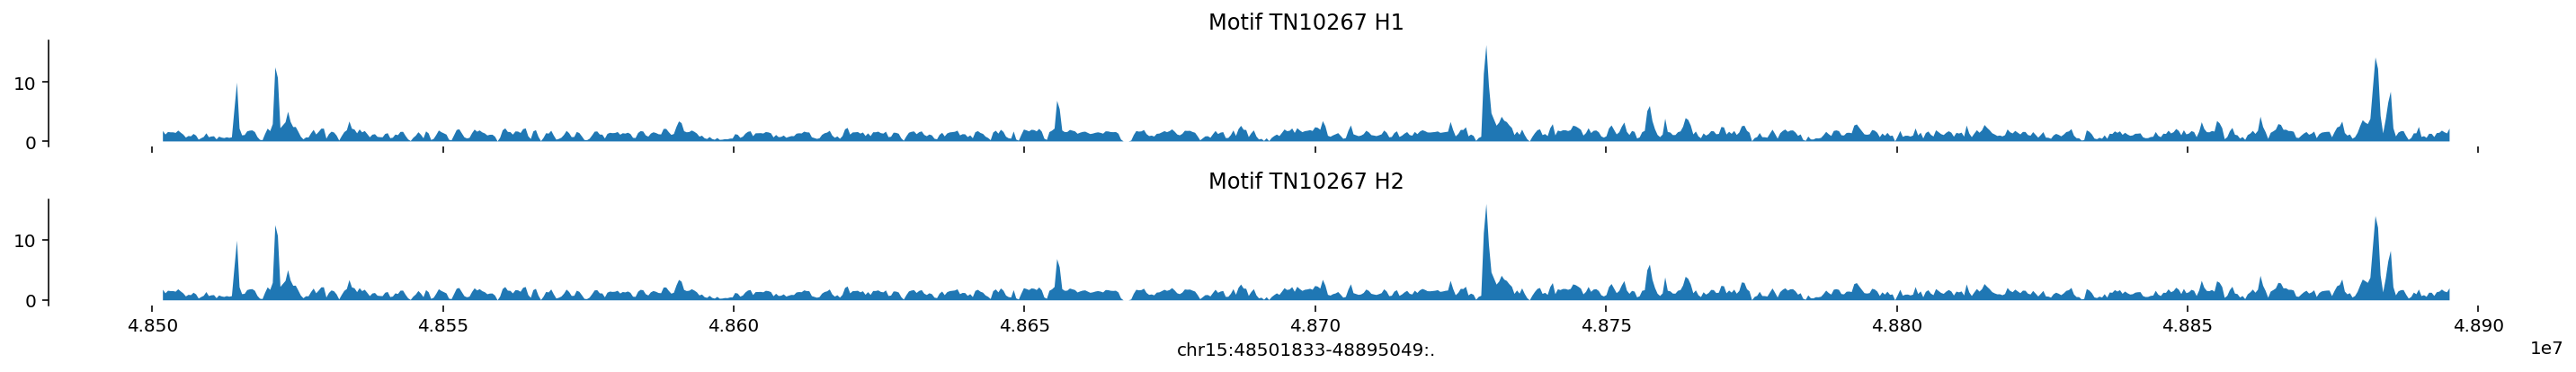

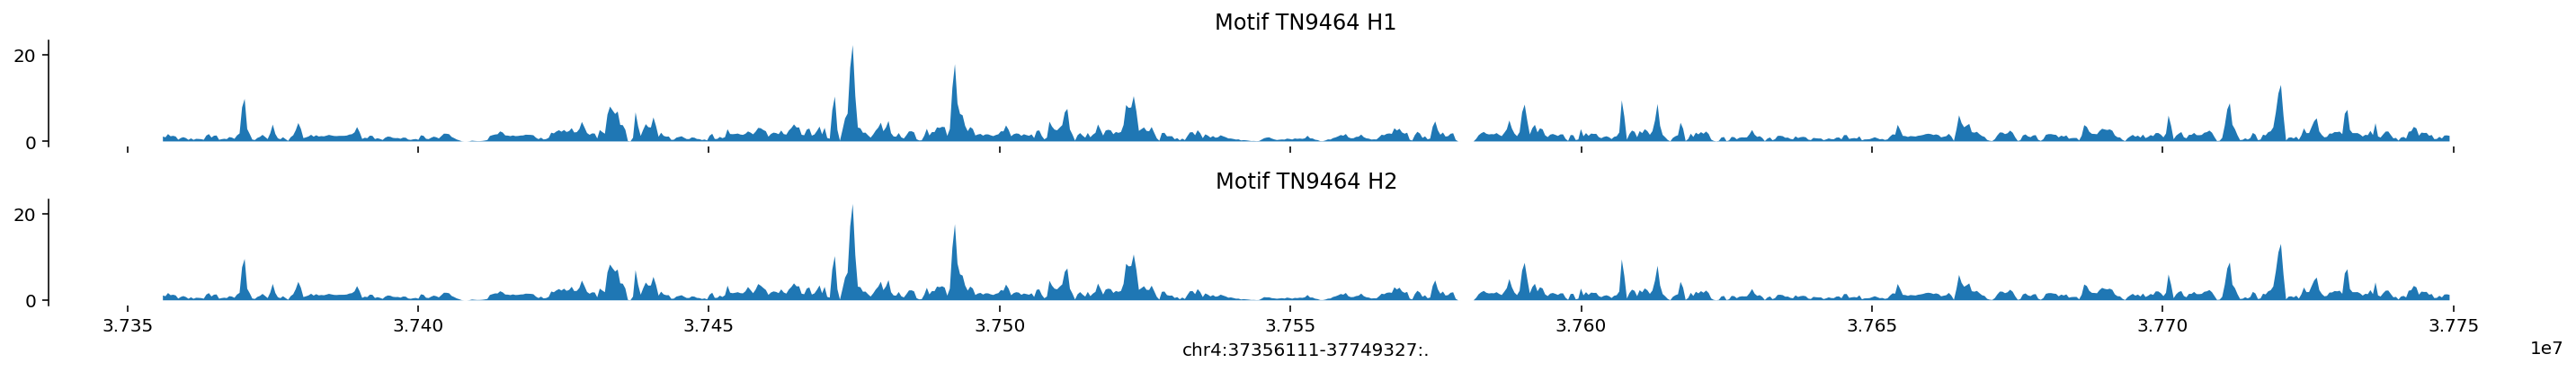

In [42]:
# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(str(interval))
    plt.tight_layout()

Gata3_first = 983 # CHIP:GATA3:T47D treated with 0.02% dimethyl sulfoxide for 1 hour
Gata3_second = 1417 # CHIP:GATA3:SH-SY5Y
Gata3_third = 2740 # CHIP:GATA3:MCF-7

plot_tracks({'Motif TP1 H1': motif_preds['TP1']['HG00096'][0][:, Gata3_first],
             'Motif TP1 H2': motif_preds['TP1']['HG00096'][1][:, Gata3_first]},
            kipoiseq.Interval('chr' + motif_int['TP1'][0], motif_int['TP1'][1], motif_int['TP1'][2]))

plot_tracks({'Motif TP2 H1': motif_preds['TP2']['HG00096'][0][:, Gata3_first],
             'Motif TP2 H2': motif_preds['TP2']['HG00096'][1][:, Gata3_first]},
            kipoiseq.Interval('chr' + motif_int['TP2'][0], motif_int['TP2'][1], motif_int['TP2'][2]))

plot_tracks({'Motif TN10267 H1': motif_preds['TN10267']['HG00096'][0][:, Gata3_first],
             'Motif TN10267 H2': motif_preds['TN10267']['HG00096'][1][:, Gata3_first]},
            kipoiseq.Interval('chr' + motif_int['TN10267'][0], motif_int['TN10267'][1], motif_int['TN10267'][2]))

plot_tracks({'Motif TN9464 H1': motif_preds['TN9464']['HG00096'][0][:, Gata3_first],
             'Motif TN9464 H2': motif_preds['TN9464']['HG00096'][1][:, Gata3_first]},
            kipoiseq.Interval('chr' + motif_int['TN9464'][0], motif_int['TN9464'][1], motif_int['TN9464'][2]))


In [ ]:
## Save the results as a pickle object

OUTPUT_DIR = '/content/drive/MyDrive/temi/TFXcan/output'

import pickle as pkl

str('{h}/four_motifs_enformer_predictions_2022-06-09.pkl'.format(h=OUTPUT_DIR))

with open(str('{h}/four_motifs_enformer_predictions_2022-06-09.pkl'.format(h=OUTPUT_DIR)), 'wb') as obj:
  pkl.dump(motif_preds, obj)

#Reading in the object is easy too

with open(str('{h}/four_motifs_enformer_predictions_2022-06-09.pkl'.format(h=OUTPUT_DIR)), 'rb') as input_obj:
  temp_preds = pkl.load(input_obj)

temp_preds

# I need to be able to select and save specific tracks
def Select_tracks(predictions, tracks_to_select=[Gata3_first, Gata3_second, Gata3_third]):

  output_dict = {}
  for k, v in predictions.items():
    temp_dict = {}
    for kv, vv in v.items():
      temp_dict[kv] = [vv[0][:, tracks_to_select], vv[1][:, tracks_to_select]]
    output_dict[k] = temp_dict

  return output_dict

Gata3_tracks_predictions = Select_tracks(motif_preds)
Gata3_tracks_predictions

j = [str(l) for l in range(1, 23)]
j.append('Y')
j

with open(str('{h}/Gata3_four_motifs_enformer_predictions_2022-06-09.pkl'.format(h=OUTPUT_DIR)), 'wb') as obj:
  pkl.dump(Gata3_tracks_predictions, obj)

In [97]:
def Select_tracks(predictions, tracks_to_select=[Gata3_first, Gata3_second, Gata3_third]):

    output_dict = {}
    for k, v in predictions.items():
        temp_dict = {}
        for kv, vv in v.items():
            temp_dict[kv] = [vv[0][:, tracks_to_select], vv[1][:, tracks_to_select]]
        output_dict[k] = temp_dict

    return output_dict

def Threshold_tracks(selected_tracks, thresh=None):
    if isinstance(None, type(selected_tracks)):
        thresh = np.mean(selected_tracks, axis=0)
    
    return np.where(selected_tracks >= thresh, 1, 0)

In [101]:
Gata3_tracks_predictions = Select_tracks(motif_preds)
tr = Gata3_tracks_predictions['TP1']['HG00096'][0]
tr

array([[0.21555452, 0.8360456 , 0.5675625 ],
       [1.5890326 , 1.7358053 , 1.0496131 ],
       [1.6248455 , 2.3480332 , 1.4383224 ],
       ...,
       [4.6923027 , 0.52216536, 3.3313963 ],
       [4.524572  , 0.37752688, 3.2929626 ],
       [3.2567918 , 0.28820166, 2.1793647 ]], dtype=float32)

In [102]:
Threshold_tracks(tr)

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [88]:
 #[:, 1]
tr.mean()

1.5789217

In [90]:
tr.mean(axis=0)

array([1.3178164, 1.8308105, 1.5881382], dtype=float32)

In [95]:
b = np.where(tr >= tr.mean(axis=0), 1, 0)
b

array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]])

In [92]:
tr

array([[0.21555452, 0.8360456 , 0.5675625 ],
       [1.5890326 , 1.7358053 , 1.0496131 ],
       [1.6248455 , 2.3480332 , 1.4383224 ],
       ...,
       [4.6923027 , 0.52216536, 3.3313963 ],
       [4.524572  , 0.37752688, 3.2929626 ],
       [3.2567918 , 0.28820166, 2.1793647 ]], dtype=float32)

In [96]:
a = np.where(tr[:,1] >= tr[:,1].mean(), 1, 0)
b[:,1] == a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,